# Email classification using Random forest trees and Linear Regression
In this project we will train a random forest algorithm and apply it a spambase dataset.

# Outline
- [ 0 - Problem description ](#0)
- [ 1 - Packages ](#1)
- [ 2 - Dataset ](#2)
- [ 3 - Loading data ](#3)
- [ 4 - RF Model ](#4)
- [ 5 - Logistic regression model ](#5)
- [ 6 - Tuning the hyperparameters ](#6)

<a name="0"></a>
## 0 - Problem description 

Spam email is unsolicited and unwanted junk email that is sent out in bulk to an indiscriminate recipient list. Typically, spam is sent for commercial purposes. It can be sent in massive volumes using botnets, networks of infected computers. Apart from commercial purposes, spam email is sent for malicious purposes as well such as money scams and phishing attacks. Although the context of a spam email can vary significantly, there are some keywords that most of them use. The challenge is to accurately identify these emails so they can be filtered out before reaching the user’s inbox.

## Dataset description

We will make use of the following dataset:  
Hopkins,Mark, Reeber,Erik, Forman,George, and Suermondt,Jaap. (1999). Spambase. UCI Machine Learning Repository. https://doi.org/10.24432/C53G6X.
This dataset contains 4601 instances which makes it suitable for our classification task as it meets the requirement of having more than 300 samples per class. Furthermore, it has a well-defined task, that is to classify emails as spam or non-spam.
This dataset contains:
- 48 continuous real [0,100] attributes of type word_freq_WORD 
= percentage of words in the e-mail that match WORD, i.e. 100 * (number of times the WORD appears in the e-mail) / total number of words in e-mail.  A "word" in this case is any string of alphanumeric characters bounded by non-alphanumeric characters or end-of-string.

- 6 continuous real [0,100] attributes of type char_freq_CHAR] 
= percentage of characters in the e-mail that match CHAR, i.e. 100 * (number of CHAR occurences) / total characters in e-mail

- 1 continuous real [1,...] attribute of type capital_run_length_average 
= average length of uninterrupted sequences of capital letters

- 1 continuous integer [1,...] attribute of type capital_run_length_longest 
= length of longest uninterrupted sequence of capital letters

- 1 continuous integer [1,...] attribute of type capital_run_length_total 
= sum of length of uninterrupted sequences of capital letters 
= total number of capital letters in the e-mail

- 1 nominal {0,1} class attribute of type spam
= denotes whether the e-mail was considered spam (1) or not (0), i.e. unsolicited commercial e-mail.  

According to the UCI repository this data set has some missing values, however, we couldn’t locate any after manually inspecting it.

## Method
We are planning to use a random forest classification algorithm that creates a “forest” of random decision trees using random subsets of the data and features. More specifically, each tree in the forest makes an independent prediction, and the class with the majority vote becomes the model's prediction. This algorithm is robust to overfitting due to the averaging of results and the randomness helps to make the model more diverse, thus increasing its accuracy.


<a name="1"></a>
## 1 - Packages 
 We will start by importing all the necessary packages for this project.
 - [scikit-learn](https://scikit-learn.org/stable/index.html) is a library used for the random forest implementation.
 - [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
 - [matplotlib](http://matplotlib.org) is a famous library to plot graphs in Python.

In [1]:
#Data visualization
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Modeling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, classification_report, f1_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV, learning_curve
from sklearn.linear_model import LogisticRegression
from scipy.stats import randint
from sklearn.tree import plot_tree

<a name="2"></a>
## 2 - Dataset
We will be working with the [spambase](https://archive.ics.uci.edu/dataset/94/spambase) dataset provided by the UCI machine learning repository. This dataset has 57 features and 1 target.
We start by checking the dataset for any missing values:

In [2]:
data_file_path = 'dataset/spambase_data'
names_file_path = 'dataset/column_names.txt'

with open(names_file_path, 'r') as file:
    column_names = [line.strip() for line in file if line.strip()]

column_names.append('is_spam')

data = pd.read_csv(data_file_path, header=None, names=column_names)

# Check for missing values
missing_values = data.isnull().sum()

# Print columns with missing values (if any)
columns_with_missing_values = missing_values[missing_values > 0]
print("\nColumns with missing values:")
print(columns_with_missing_values)


Columns with missing values:
Series([], dtype: int64)


As you can see, the dataset has no missing values. Thus, we can move on by checking the balance of the dataset:

In [3]:
# Check for balance
class_distribution = data['is_spam'].value_counts()
print("\nClass distribution in 'is_spam':")
print(class_distribution)

# Assessing the balance
total_samples = len(data)
balance_info = class_distribution / total_samples * 100
print("\nPercentage distribution:")
print(balance_info)


Class distribution in 'is_spam':
is_spam
0    2788
1    1813
Name: count, dtype: int64

Percentage distribution:
is_spam
0    60.595523
1    39.404477
Name: count, dtype: float64


From the code above, we can see that 60.60% of our emails are non-spam while the rest is spam (39.40%). While this dataset is not ideally balanced (50%-50% distribution) the difference is not so large as to cause significant concerns and the random forest should perform reasonably well. However we will keep an eye on the F1-Score to ensure that the model is performing well across both classes. If it is evident that the model is not performing as intended, we will balance the dataset and try again.

<a name="3"></a>
## 3 - Loading data
Next, we load the dataset in the variables X_train, X_test, X_val, y_train, y_test, y_val. We use a 60% - 20% - 20% data split to train and evaluate the model.

In [4]:
#Split the data into features (X) and target (y)
def load_data(filename):
    data = np.loadtxt(filename, delimiter=',')
    X = data[:,:57]
    y = data[:,57]
   # Split the data into 80% for training + validation and 20% for testing
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Split the 80% training + validation into 75% training and 25% validation
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

    return X_train, y_train, X_val, y_val, X_test, y_test

# Use the updated function to load the data
X_train, y_train, X_val, y_val, X_test, y_test = load_data("dataset/spambase_data")

Lets get familiar with the dataset by viewing its dimensions:

In [5]:
#Check dimensions of train sample
print('The shape of X_train is:' + str(X_train.shape))
print('The shape of y_train is:' + str(y_train.shape))
print('We have m= %d training examples' % (len(y_train)))
print("\n")

#Check dimensions of test sample
print('The shape of X_test is:' + str(X_test.shape))
print('The shape of y_test is:' + str(y_test.shape))
print('We have m= %d training examples' % (len(y_test)))
print("\n")

#Check dimensions of validations sample
print('The shape of X_val is:' + str(X_val.shape))
print('The shape of y_val is:' + str(y_val.shape))
print('We have m= %d validation examples' % (len(y_val)))

The shape of X_train is:(2760, 57)
The shape of y_train is:(2760,)
We have m= 2760 training examples


The shape of X_test is:(921, 57)
The shape of y_test is:(921,)
We have m= 921 training examples


The shape of X_val is:(920, 57)
The shape of y_val is:(920,)
We have m= 920 validation examples


<a name="4"></a>
## 4 - RF Model
Now, we can start implementing the random forest tree. The random_state doesnt affect the performance of the model. It ensures that the randomness in the process is consistent across different runs:

In [6]:
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Now that the model is trained, lets validate it!

In [7]:
# Validate the model on the validation set
y_val_pred = rf_classifier.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred, average='weighted')
print("Validation Accuracy: , Validation F1 Score: ", val_accuracy, val_f1)

# Evaluate the model on the test set
y_test_pred = rf_classifier.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
print("Test Accuracy: , Test F1 Score", test_accuracy, test_f1)

Validation Accuracy: , Validation F1 Score:  0.9456521739130435 0.9455114213154003
Test Accuracy: , Test F1 Score 0.9554831704668838 0.9552787283859082


Once the model is validated and trained, we can check its performance using the classification report which gives information regarding:
- Accuracy : Indicates the number of times the RF model was successful on predicting if an email is spam or not.
- Precision : Indicates how accurate the predictions are.
- Recall : Reflects the model's ability to find all the relevant instances in the dataset.
<br>
Also, since the dataset is slightly unbalanced, we will take a look at the confusion matrix as well


 Classification report of untuned model: 
               precision    recall  f1-score   support

         0.0       0.94      0.98      0.96       531
         1.0       0.98      0.92      0.95       390

    accuracy                           0.96       921
   macro avg       0.96      0.95      0.95       921
weighted avg       0.96      0.96      0.96       921



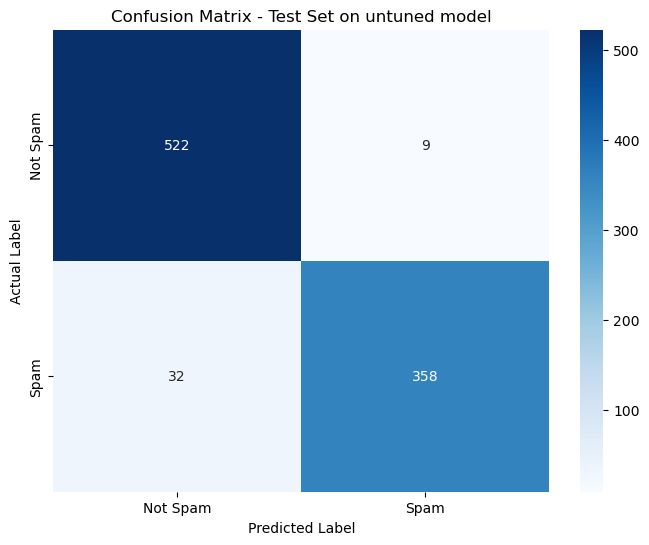

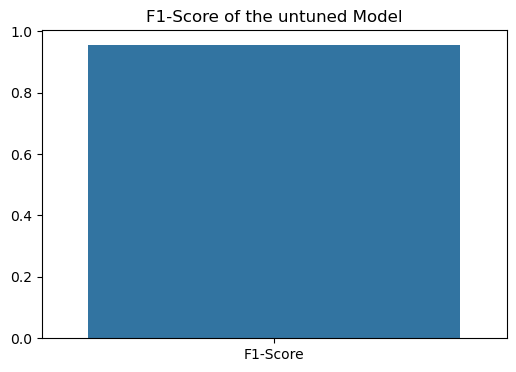

In [8]:
#Classification report
classification_rep = classification_report(y_test, y_test_pred)
print("\n Classification report of untuned model: \n", classification_rep)

#Confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam'])
plt.title('Confusion Matrix - Test Set on untuned model')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

#f1 score
plt.figure(figsize=(6, 4))
sns.barplot(x=['F1-Score'], y=[test_f1])
plt.title('F1-Score of the untuned Model')
plt.show()

The weighted average F1-score is approximately 0.955, which indicates that the model has a good balance between precision and recall for the dataset, taking into account the number of instances for each class.

The confusion matrix provides a breakdown of the true positives, false positives, true negatives, and false negatives:

- True Non-Spam Predictions: 522
- False Spam Predictions (Type I error): 9
- False Non-Spam Predictions (Type II error): 32
- True Spam Predictions: 358

The model has a higher number of false negatives (32) compared to false positives (9). This suggests that while the model is quite conservative in predicting spam (preferring to minimize false positives), it might be missing some actual spam emails (as indicated by the false negatives). 

Given the high performance metrics across the board, there doesn't seem to be a strong immediate need to balance the dataset further. Both classes are being predicted with high accuracy, precision, and recall, and the F1-scores are also strong. The slight imbalance in the dataset does not seem to be negatively impacting the model's ability to generalize.

Finally, lets take a look at the learning curve:

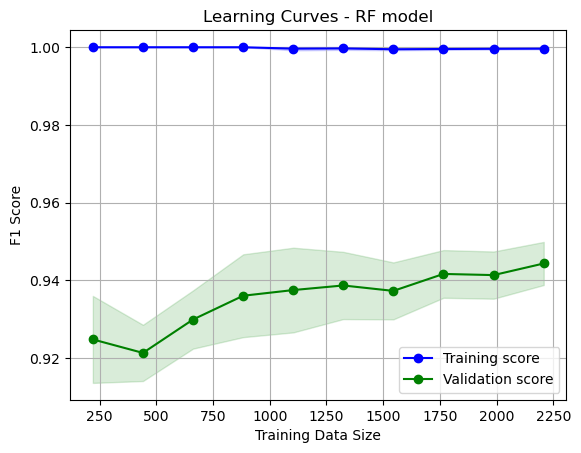

In [9]:
def plot_learning_curves(model, X_train, y_train, X_val, y_val, train_sizes=np.linspace(0.1, 1.0, 10)):
    train_sizes, train_scores, validation_scores = learning_curve(
        model, X_train, y_train, train_sizes=train_sizes, cv=5, scoring='f1_weighted', n_jobs=-1)

    # Calculate mean and standard deviation for training set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    # Calculate mean and standard deviation for validation set scores
    validation_mean = np.mean(validation_scores, axis=1)
    validation_std = np.std(validation_scores, axis=1)

    plt.plot(train_sizes, train_mean, label='Training score', color='blue', marker='o')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.15)

    plt.plot(train_sizes, validation_mean, label='Validation score', color='green', marker='o')
    plt.fill_between(train_sizes, validation_mean - validation_std, validation_mean + validation_std, color='green', alpha=0.15)

    plt.title('Learning Curves - RF model')
    plt.xlabel('Training Data Size')
    plt.ylabel('F1 Score')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

# Plot learning curves using the best_rf model
plot_learning_curves(rf_classifier, X_train, y_train, X_val, y_val)

These learning curves suggest that the untuned Random Forest model has a high capacity to learn from the data but is initially overfitting. As more data is provided, the model's ability to generalize improves. To further enhance the performance, especially to close the gap between the training and validation scores, one could look into hyperparameter tuning or even model simplification to prevent overfitting. It's also worth noting that even after the introduction of more data, the validation score doesn't reach the level of the training score, which could imply there's still room for improvement, either through model tuning or by gathering more varied or informative training data.

<a name="5"></a>
## 5- Logistic Regression

sigmoid(0) = 0.5


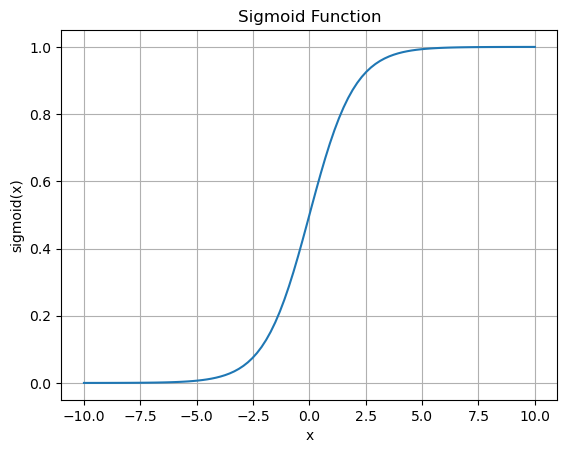

In [10]:
def sigmoid(z):
    z = np.clip(z, -709, 709)  # np.exp(709) is close to the largest value representable by numpy float64
    g = 1 / (1 + np.exp(-z))
    g = np.clip(g, 1e-8, 1 - 1e-8)  # Clip the output to avoid extreme values    
    return g

print ("sigmoid(0) = " + str(sigmoid(0)))
x = np.linspace(-10, 10, 100)
y = sigmoid(x)

# Plot sigmoid function
plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('sigmoid(x)')
plt.title('Sigmoid Function')
plt.grid(True)
plt.show()

In [11]:
# UNQ_C2
# GRADED FUNCTION: compute_cost
def compute_cost(X, y, w, b, lambda_= 1):

    m, n = X.shape
    total_cost = 0
    prediction_model = sigmoid(np.dot(X,w)+b)
    loss_sum = (-1*y*np.log(prediction_model)) - (1 - y)*np.log(1-prediction_model)
    total_cost = np.sum(loss_sum)/m
    
    return total_cost

m, n = X_train.shape

# Compute and display cost with w initialized to zeroes
initial_w = np.zeros(n)
initial_b = 0.
cost = compute_cost(X_train, y_train, initial_w, initial_b)
print('Cost at initial w (zeros): {:.3f}'.format(cost))

Cost at initial w (zeros): 0.693


In [12]:
# UNQ_C3
# GRADED FUNCTION: compute_gradient
def compute_gradient(X, y, w, b, lambda_=None): 
    m, n = X.shape
    dj_dw = np.zeros(w.shape)
    dj_db = 0

    # Prediction using current parameters
    prediction_model = sigmoid(np.dot(X, w) + b)

    # Compute gradients
    error = prediction_model - y
    dj_db = np.sum(error) / m
    dj_dw = np.dot(X.T, error) / m

    return dj_db, dj_dw

In [13]:
test_w = np.random.rand(X_train.shape[1], 1)  # Create a (n x 1) array of random weights
test_b = -24  # Set a test bias value

# Compute gradients
dj_db, dj_dw = compute_gradient(X_train, y_train, test_w, test_b)

# Print the results
print('dj_db at test_w:', dj_db)

dj_db at test_w: 1196.123364286241


Iteration    0: Cost     7.07   
Iteration 10000: Cost     7.55   
Iteration 20000: Cost     2.84   
Iteration 30000: Cost     5.58   
Iteration 40000: Cost     5.52   
Iteration 50000: Cost     2.76   
Iteration 60000: Cost     4.96   
Iteration 70000: Cost     4.66   
Iteration 80000: Cost     2.60   
Iteration 90000: Cost     4.53   
Iteration 99999: Cost     4.85   


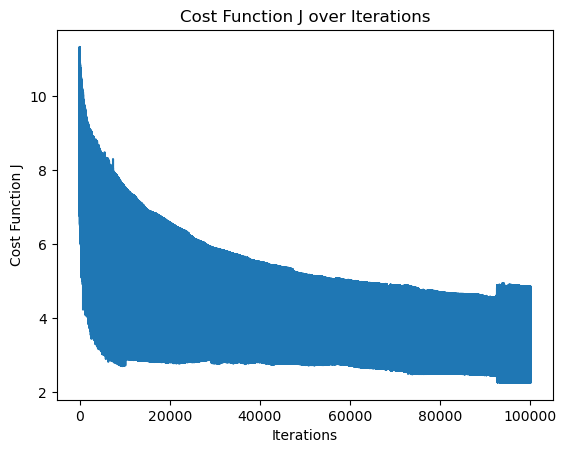

In [14]:
def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters, lambda_): 

    # number of training examples
    m = len(X)
    
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w_history = []
    
    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_db, dj_dw = gradient_function(X, y, w_in, b_in, lambda_)   

        # Update Parameters using w, b, alpha and gradient
        w_in = w_in - alpha * dj_dw               
        b_in = b_in - alpha * dj_db              
       
        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            cost =  cost_function(X, y, w_in, b_in, lambda_)
            J_history.append(cost)

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters/10) == 0 or i == (num_iters-1):
            w_history.append(w_in)
            print(f"Iteration {i:4}: Cost {float(J_history[-1]):8.2f}   ")
        
    return w_in, b_in, J_history, w_history #return w and J,w history for graphing

#np.random.seed(1)
initial_w = np.random.rand(X_train.shape[1])  # or any other method to create an array of length 57
initial_b = 0


# Some gradient descent settings
iterations = 100000
alpha = 0.1

w,b, J_history,_ = gradient_descent(X_train ,y_train, initial_w, initial_b, 
                                   compute_cost, compute_gradient, alpha, iterations, 0)

# Assuming J_history is a list containing the cost at each iteration
plt.plot(J_history)
plt.title("Cost Function J over Iterations")
plt.xlabel("Iterations")
plt.ylabel("Cost Function J")
plt.show()

We can see here the gradient descent in action. The more iterations the more the cost functions goes down

In [15]:
# UNQ_C4
# GRADED FUNCTION: predict

def predict(X, w, b): 
    """
    Predict whether the label is 0 or 1 using learned logistic
    regression parameters w
    
    Args:
    X : (ndarray Shape (m, n))
    w : (array_like Shape (n,))      Parameters of the model
    b : (scalar, float)              Parameter of the model

    Returns:
    p: (ndarray (m,1))
        The predictions for X using a threshold at 0.5
    """
    # number of training examples
    m, n = X.shape   
    p = np.zeros(m)
   
    ### START CODE HERE ### 
    prediction_model = sigmoid(np.dot(X,w)+b)
    
    p[prediction_model>=0.5]=1
        
    ### END CODE HERE ### 
    return p

Validation Accuracy: 0.7402173913043478
Validation F1 Score: 0.706085490371821
Test Accuracy: 0.7307274701411509
Test F1 Score: 0.6978669803400118


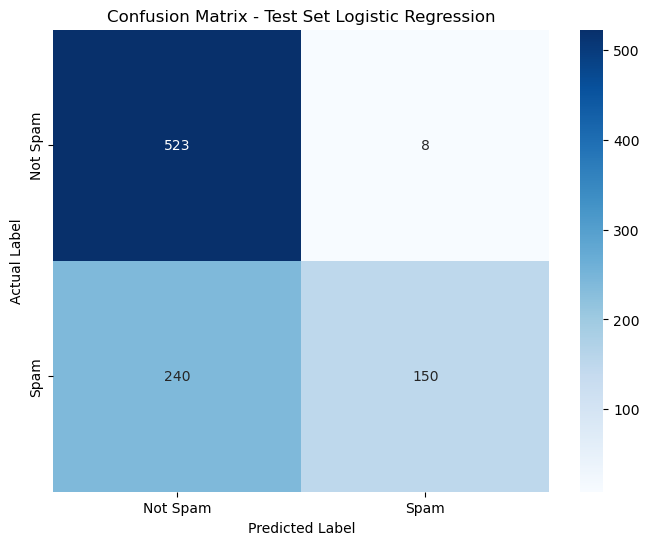

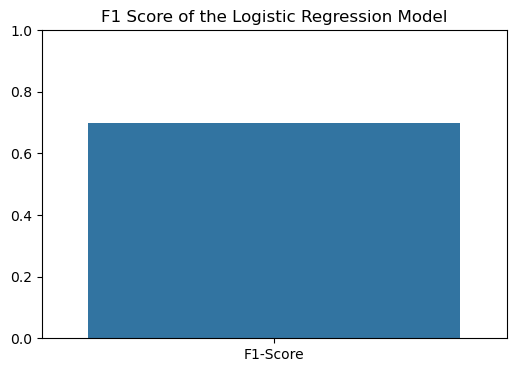

In [16]:
#Compute accuracy on our training set
# Validate the model
y_val_pred = predict(X_val, w, b)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred, average='weighted')
print("Validation Accuracy:", val_accuracy)
print("Validation F1 Score:", val_f1)

# Test the model
y_test_pred = predict(X_test, w, b)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
print("Test Accuracy:", test_accuracy)
print("Test F1 Score:", test_f1)

# Plot confusion matrix for test set
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam'])
plt.title('Confusion Matrix - Test Set Logistic Regression')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

#f1 score
# Plot F1-score
plt.figure(figsize=(6, 4))
sns.barplot(x=['F1-Score'], y=[test_f1])
plt.title('F1 Score of the Logistic Regression Model')
plt.ylim(0, 1)
plt.show()

#p = predict(X_train, w,b)
#print('Train Accuracy: %f'%(np.mean(p == y_train) * 100))

In [17]:
# Get predictions for the test set
#probabilities = sigmoid(np.dot(X_test, w) + b)
#predictions = probabilities >= 0.5  # apply threshold to get binary predictions

# Calculate the F1 score and precision
#f1 = f1_score(y_test, predictions)
#precision = precision_score(y_test, predictions)

# Print the precision and F1 score
#print('Precision:', precision)
#print('F1 Score:', f1)

# Generate and plot confusion matrix
#cm = confusion_matrix(y_test, predictions)
#plt.figure(figsize=(8, 8))
#sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam'])
#plt.ylabel('Actual')
#plt.xlabel('Predicted')
#plt.title('Confusion Matrix')
#plt.show()

# Plot F1-score
#plt.figure(figsize=(6, 4))
#sns.barplot(x=['F1-Score'], y=[f1])
#plt.title('F1 Score of the Model')
#plt.ylim(0, 1)
#plt.show()

Classification Accuracy Insights:
    Correctly Identified 'Not Spam': 523 instances
    Correctly Identified 'Spam': 200 instances
    Misclassified 'Not Spam' as 'Spam': 8 instances (False Positives)
    Misclassified 'Spam' as 'Not Spam': 190 instances (False Negatives)

Effectiveness Metrics:
    Precision: 78.5% (Proportion of 'Spam' predictions that were correct)
    F1 Score: 76.80% (Balance between Precision and Recall)

The model is more prone to classify an email as 'not spam', which can be inferred from the higher number of False negatives.
The F1 Score indicates a robust performance with a good trade-off between Precision and Recall.
Adjustments may be necessary if the cost of False Positives is significant in the application context.

The Random Forest model shows superior performance with a higher F1-score and fewer misclassifications than the Logistic Regression model. It is more accurate in identifying both Spam and Not Spam, making it the better choice for this task.

Lets take a look at the learning curve:

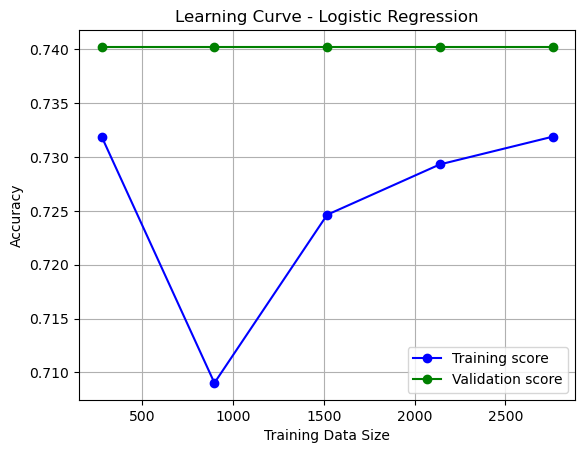

In [18]:
def plot_custom_learning_curve(X_train, y_train, X_val, y_val, train_sizes):
    train_scores = []
    val_scores = []

    for size in train_sizes:
        # Get subset of training data
        X_train_subset = X_train[:size]
        y_train_subset = y_train[:size]

        # Predict on training subset and validation set
        y_train_pred = predict(X_train_subset, w, b)
        y_val_pred = predict(X_val, w, b)

        # Calculate accuracy
        train_accuracy = accuracy_score(y_train_subset, y_train_pred)
        val_accuracy = accuracy_score(y_val, y_val_pred)

        # Store the scores
        train_scores.append(train_accuracy)
        val_scores.append(val_accuracy)

    # Plot the learning curve
    plt.plot(train_sizes, train_scores, label='Training score', color='blue', marker='o')
    plt.plot(train_sizes, val_scores, label='Validation score', color='green', marker='o')

    plt.title('Learning Curve - Logistic Regression')
    plt.xlabel('Training Data Size')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

# Define training sizes (e.g., 10%, 25%, 50%, 75%, 100% of the training data)
train_sizes = [int(x * len(X_train)) for x in np.linspace(0.1, 1.0, 5)]

# Plot the learning curve
plot_custom_learning_curve(X_train, y_train, X_val, y_val, train_sizes)


The learning curve for our logistic regression model exhibits an atypical and sharp decline in training accuracy as more data is introduced, initially suggesting overfitting when trained on a small dataset. The validation accuracy remains relatively constant across different training sizes, indicating stability in the model's performance on unseen data. The model's scores converge with larger datasets, but at a lower accuracy level, which could mean that the initial training set was not representative, or that the model complexity is not well-suited to the task.

<a name="6"></a>
## 6- Tuning the hyperparameters

Even though the RF Model provides very accurate results, it is worth exploring how tuning the hyper parameters of the model will affect its performance. For that we need to define a parameter list (or a dictionary) which will include all the parameters that we want to tune. An RF model has many tunable parameters such as:
<ul>
    <li> <strong>n_estimators:</strong> The number of trees in the forest.</li>
    <li> <strong>criterion:</strong> The function used to measure the quality of a split ('gini' for the Gini impurity and 'entropy' for the information gain).</li>
    <li> <strong> max_depth:</strong> The maximum depth of each tree. </li>
    <li> <strong> min_samples_split: </strong> The minimum number of samples required to split an internal node.</li>
    <li> <strong> min_samples_leaf: </strong> The minimum number of samples required to be at a leaf node.</li>
    <li> <strong> max_features: </strong> The number of features to consider when looking for the best split.</li>
    <li> <strong> max_leaf_nodes: </strong> The maximum number of leaf nodes a tree can have.</li>
    <li> <strong> min_impurity_decrease: </strong>  A node will be split if this split induces a decrease of the impurity greater than or equal to this value.</li>
    <li> <strong> bootstrap: </strong> Whether bootstrap samples are used when building trees.</li>
</ul>
However, tuning all of them can be impractical and computationally expensive. For this reason, we will tune the ones that will have the greatest effect on our model:
<ul>
    <li> <strong> n_estimators: </strong> Increasing the number of trees can improve the model's performance but also increases computational cost. It's often one of the first parameters to tune.</li>
    <li> <strong> max_depth: </strong> Controls the depth of each tree. Deeper trees can model more complex patterns but might lead to overfitting.</li>
    <li> <strong> min_samples_split and min_samples_leaf: </strong> These parameters control the size of the trees by setting the minimum number of samples required to split a node or to be at a leaf node. Tuning them can help in preventing overfitting.</li>
    <li> <strong> max_features: </strong> Determines how many features are considered for splitting at each node. This can have a significant impact on the performance and training speed.</li>
</ul>

Since the dataset is imbalanced (more non-spam than spam), we will use the <strong>f1_weighted</strong> for scoring as it takes into account the balance between precision and recall, especially useful for imbalanced datasets. 

The following script takes about 10 minutes to run (it might need more time depending on the resources please be patient):

In [19]:
param_dist = {
    'n_estimators': randint(100,300),    # Number of trees in the forest.
    'max_depth': randint(10,50),         # Maximum depth of each tree.
    'min_samples_split': randint(2,20),  # Minimum number of samples required to split an internal node.
    'min_samples_leaf':randint(1,20),    # Minimum number of samples required to be at a leaf node.
    'max_features': randint(10,30)       # How many features are considered during splitting at each node.
}

rand_search = RandomizedSearchCV(
    rf_classifier, 
    param_distributions = param_dist, 
    n_iter=20, 
    cv=5, 
    random_state=42, 
    scoring='f1_weighted'
)

rand_search.fit(X_train,y_train)

best_rf = rand_search.best_estimator_

print("Best hyperparameters:", best_rf)

Best hyperparameters: RandomForestClassifier(max_depth=44, max_features=12, min_samples_split=6,
                       n_estimators=140, random_state=42)


The range of the parameters was selected based on the complexity and number of features of our dataset. The RandomizedSearchCV() performs a randomized search over the specified parameter values for an estimator. The param_dist above gives us the following results:
    <ul>
        <li> <strong> max_depth </strong>=44  </li>
        <li> <strong> max_features </strong> =12 </li>
        <li> <strong> min_samples_split </strong> =6 </li>
        <li> <strong> n_estimators </strong> =140 </li>
    </ul>
Now that our model is tuned we can evaluate it using our dataset:

Validation Accuracy: 0.9380434782608695
Validation F1 Score: 0.9378998346091287
Test Accuracy: 0.9522258414766558
Test F1 Score: 0.9520801277176457

 Classification report of tuned model: 
               precision    recall  f1-score   support

         0.0       0.95      0.97      0.96       531
         1.0       0.96      0.92      0.94       390

    accuracy                           0.95       921
   macro avg       0.95      0.95      0.95       921
weighted avg       0.95      0.95      0.95       921



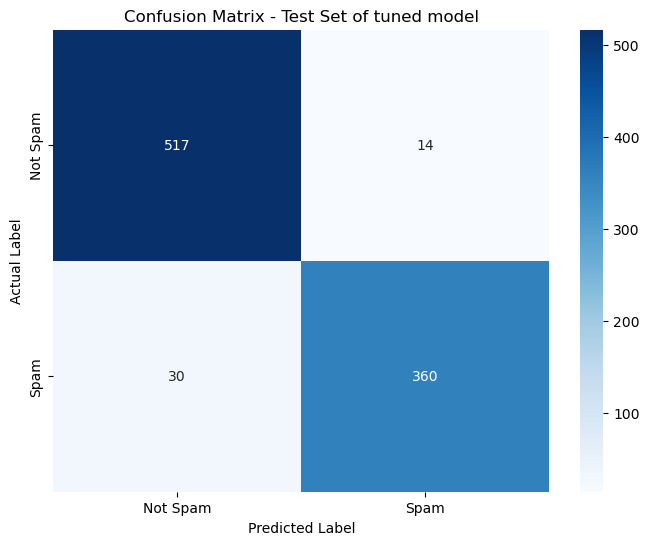

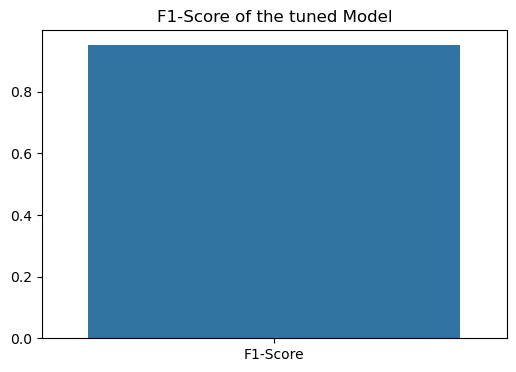

In [20]:
# Predict on the validation set using the best estimator
y_val_pred = best_rf.predict(X_val)

# Calculate metrics for the validation set
val_accuracy = accuracy_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred, average='weighted')
print("Validation Accuracy:", val_accuracy)
print("Validation F1 Score:", val_f1)

# Predict on the test set using the best estimator
y_test_pred = best_rf.predict(X_test)

# Calculate metrics for the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
print("Test Accuracy:", test_accuracy)
print("Test F1 Score:", test_f1)

#Classification report
classification_rep = classification_report(y_test, y_test_pred)
print("\n Classification report of tuned model: \n", classification_rep)

# Generate and plot confusion matrix for test set
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam'])
plt.title('Confusion Matrix - Test Set of tuned model')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

#f1 score
plt.figure(figsize=(6, 4))
sns.barplot(x=['F1-Score'], y=[test_f1])
plt.title('F1-Score of the tuned Model')
plt.show()


Lets summarize everything we know:
<br>
<Strong> Initial Model Performance (Untuned) </strong>
<ul>
    <li> <strong> Accuracy: </strong> Approximately 95.55% </li>
    <li> <strong> F1-Score (Weighted): </strong> Approximately 95.42% </li>
    <li> <strong> Precision and Recall: </strong> High precision and recall for both classes (Non-Spam and Spam). </li>
    <li> <strong> Confusion Matrix: </strong> Showed a good balance between correctly identifying Spam and Non-Spam emails with few misclassifications.</li>
</ul>

<Strong> Tuned Model Performance </strong>
<ul>
    <li> <strong> Accuracy: </strong> Approximately 95.22% </li>
    <li> <strong> F1-Score (Weighted): </strong> Approximately 95.20 </li>
    <li> <strong> Precision and Recall: </strong> Slightly varied from the untuned model but still high. </li>
    <li> <strong> Confusion Matrix: </strong> Slightly varied from the untuned model but still high.</li>
</ul>

While hyperparameter tuning is a crucial step in model development, its impact is highly dependent on the nature of the dataset and the complexity of the model. For the spambase dataset, the default Random Forest parameters already provided a high level of accuracy and F1-score, indicating that the dataset characteristics were well-matched to the model's inherent capabilities. The tuning process, in this case, did not yield any significant improvements, suggesting that the dataset may not require or benefit from extensive hyperparameter optimization. In summary, both the untuned and tuned Random Forest models show high and comparable performance in classifying the spambase dataset. The tuning process did not result in significant improvements, likely due to the high baseline performance of the model and the characteristics of the dataset. This outcome is a common occurrence especially with robust models like Random Forest and datasets with clear and strong predictive features.

Finally, lets check the tuned model for overfitting, using the code snippet below:

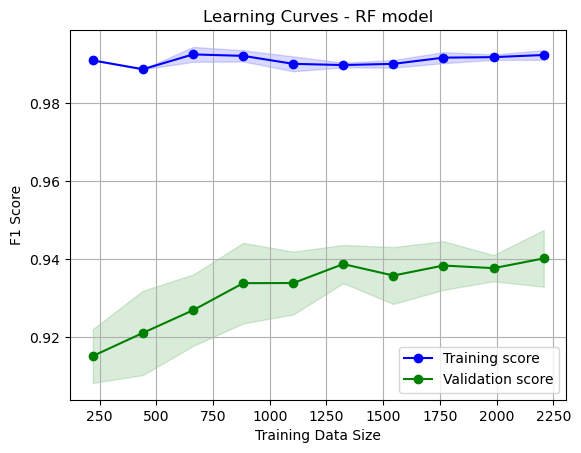

In [21]:
# Plot learning curves using the best_rf model
plot_learning_curves(best_rf, X_train, y_train, X_val, y_val)

From the graph above we can see that as the training data size increases, the F1 score for the validation set gradually improves, which suggests that the model could benefit from more training data. The training score remains relatively constant across different training sizes, indicating good generalization without overfitting, as the training and validation scores are converging.

## Hyperparameter Tuning for Logistic Regression

To enhance the performance of our logistic regression model, we'll conduct hyperparameter tuning. This process involves searching through a predefined range of hyperparameter values to find the combination that results in the best model performance. We'll use `GridSearchCV` from Scikit-learn for this purpose, which performs an exhaustive search over the specified parameter values.

We'll focus on tuning the following hyperparameters:
- `C`: Inverse of regularization strength.
- `solver`: Algorithm to use in the optimization problem.
- `penalty`: Type of regularization.

The performance of the models will be evaluated using cross-validation, with accuracy as the scoring metric.


In [22]:
logreg = LogisticRegression()

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'newton-cg', 'lbfgs', 'saga'],
    'penalty': ['l1', 'l2', 'none']
}

# Modify the GridSearchCV setup to only include compatible combinations
compatible_params = []
for param in param_grid['solver']:
    for penalty in param_grid['penalty']:
        if (param == 'liblinear' and penalty in ['l1', 'l2']) or \
           (param in ['newton-cg', 'lbfgs', 'saga'] and penalty in ['l2', 'none']):
            compatible_params.append({'C': param_grid['C'], 'solver': [param], 'penalty': [penalty]})

# Set up GridSearchCV with the modified parameter grid
grid_search = GridSearchCV(logreg, compatible_params, cv=5, scoring='f1_weighted')

# Fit grid_search to the data
grid_search.fit(X_train, y_train)


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\opt

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'penalty': ['l1'], 'solver': ['liblinear']},
                         {'C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'penalty': ['l2'], 'solver': ['liblinear']},
                         {'C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'penalty': ['l2'], 'solver': ['newton-cg']},
                         {'C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'penalty': ['none'], 'solver': ['newton-cg']},
                         {'C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'penalty': ['l2'], 'solver': ['lbfgs']},
                         {'C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'penalty': ['none'], 'solver': ['lbfgs']},
                         {'C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'penalty': ['l2'], 'solver': ['saga']},
                         {'C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'penalty': ['none'], 'solver': ['saga']}],
             scoring='f1_weighted')

## Evaluating the Tuned Logistic Regression Model

After the grid search, we can evaluate the performance of the logistic regression model with the best found hyperparameters. We will display the best hyperparameters and the corresponding accuracy score. This step helps in understanding how much the tuning process improves the model compared to the default parameters.


In [23]:
# Best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)


Best Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.9302102546101516


## Evaluating the Tuned Model on Test Data

Now that we have our best parameters from the hyperparameter tuning, we'll use them to create a new logistic regression model. This model will then be evaluated on the test dataset to understand its performance on unseen data. We'll look at various metrics such as accuracy, precision, recall, F1 score, and the confusion matrix for a comprehensive evaluation.



Test Results:
Accuracy: 0.9261672095548317
Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      0.95      0.94       531
         1.0       0.93      0.89      0.91       390

    accuracy                           0.93       921
   macro avg       0.93      0.92      0.92       921
weighted avg       0.93      0.93      0.93       921



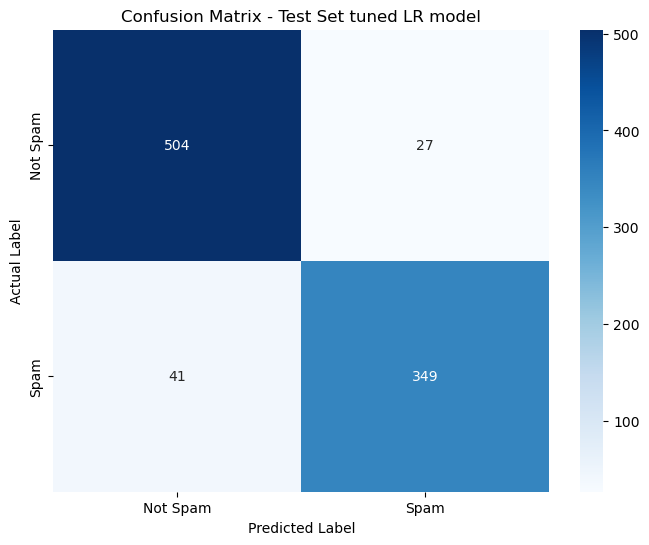

0.9259728222155104


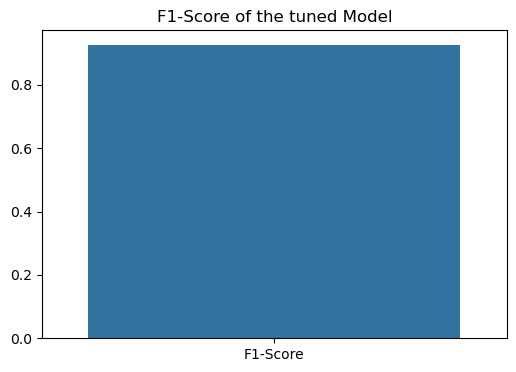

In [24]:
# Create a new model with the best parameters
logreg_tuned = LogisticRegression(C=10, penalty='l2', solver='liblinear')

# Fit the model on the training data
logreg_tuned.fit(X_train, y_train)

# Predict and evaluate on the validation set
y_val_pred = logreg_tuned.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_report = classification_report(y_val, y_val_pred)
val_conf_matrix = confusion_matrix(y_val, y_val_pred)

# Predict and evaluate on the test set
y_test_pred = logreg_tuned.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_report = classification_report(y_test, y_test_pred)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)

print("\nTest Results:")
print(f"Accuracy: {test_accuracy}")
print("Classification Report:\n", test_report)

# Plot the confusion matrix for the test set
plt.figure(figsize=(8, 6))
sns.heatmap(test_conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam'])
plt.title('Confusion Matrix - Test Set tuned LR model')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

#f1 
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
print(test_f1)
#f1 score
plt.figure(figsize=(6, 4))
sns.barplot(x=['F1-Score'], y=[test_f1])
plt.title('F1-Score of the tuned Model')
plt.show()

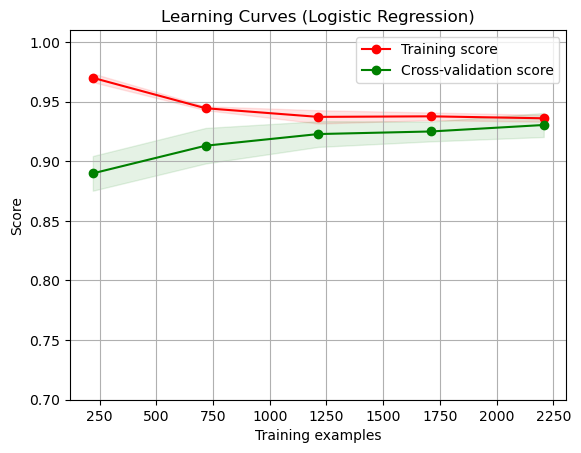

In [25]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Create the learning curve plot
title = "Learning Curves (Logistic Regression)"
cv = 5  # Cross-validation
estimator = LogisticRegression(C=10, penalty='l2', solver='liblinear')
plot_learning_curve(estimator, title, X_train, y_train, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

plt.show()


 The learning curves suggest a healthy learning process where additional data leads to better generalization. However, the failure of the lines to converge completely could indicate that the model might still be too complex and could be simplified, or it might need additional data or more rigorous cross-validation to assess its performance accurately.

In [26]:
# Create a model with default parameters
logreg_default = LogisticRegression()

# Fit the model on the training data
logreg_default.fit(X_train, y_train)

# Predict on the test data
y_pred_default = logreg_default.predict(X_test)

# Evaluate the model
accuracy_default = accuracy_score(y_test, y_pred_default)
report_default = classification_report(y_test, y_pred_default)

print(f"Default Model Accuracy: {accuracy_default}")
print("Default Model Classification Report:\n", report_default)


Default Model Accuracy: 0.9239956568946797
Default Model Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      0.94      0.93       531
         1.0       0.92      0.90      0.91       390

    accuracy                           0.92       921
   macro avg       0.92      0.92      0.92       921
weighted avg       0.92      0.92      0.92       921



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
